In [146]:
from abafrank_lib.Function_Library import Parse_SIF
from abafrank_lib.Function_Library import Read_Simulation_Settings
from abafrank_lib.Function_Library import Read_Initial_Velocity
from abafrank_lib.Function_Library import Normalize
from abafrank_lib.Function_Library import Get_Normal
import numpy as np
import os
import json
import math
import math as m
import plotly as py
import matplotlib.pyplot as plt

In [147]:
# Set the simulation folder
#checkpoint = 'InitialCompleted'
Normal_Method = 1
median_extension = .5
sim_folder = 'E:\\mitchrecreation\\oc_100_0_0'
os.chdir(sim_folder)


In [148]:
# SimDict = Read_Simulation_Settings( checkpoint )
from R_Curve import R_curve
[VX, VY, VZ, SimDict['NAME'] , COORD] = Read_Initial_Velocity()
# Determine how the new file name should increment
#if SimDict['FLAG'] == True and SimDict['Frame_Index'] == -1:
    # We have crack growth in the previous step, no growth in current step, just increment to next step
Step_increment = 1
#elif SimDict['FLAG'] == False:
    # We don't have crack growth in the previous step, nor in the current step
    #Step_increment = ( SimDict['Frame_Index'] + 11 ) + 1
# Set filenames
SimDict['NAME'] = 'perpness'
print(SimDict['NAME'])
local_inp_file = SimDict['NAME'] + '_LOCAL.inp'
global_inp_file = SimDict['NAME'] + '_GLOBAL.inp'
base_name = SimDict['NAME']
#original_file_crk = base_name + '_original.crk' #TODO MISSING THIS FILE
original_file_frt = base_name + '_original.frt'
original_front = open(original_file_frt,'r')
lines = list( original_front.readlines() )
original_front.close()
# Read from outer surface nodes to determine normal
F = open( 'OUTER_SURF.json' ,'r')
LOC = json.load(F)
F.close()

perpness


##############################                 FRANC 3D: 6 neighboring crack front nodes will be averaged.


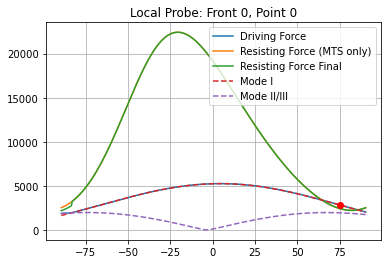

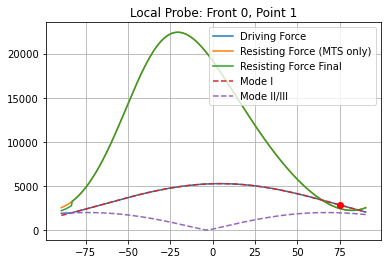

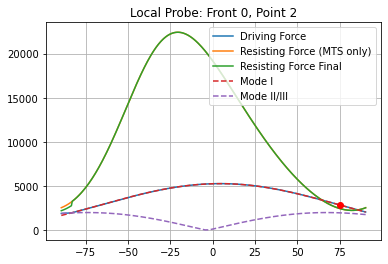

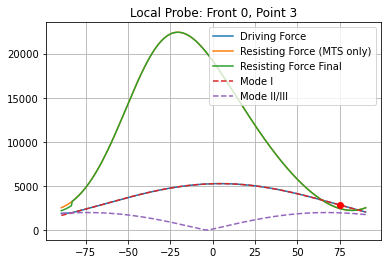

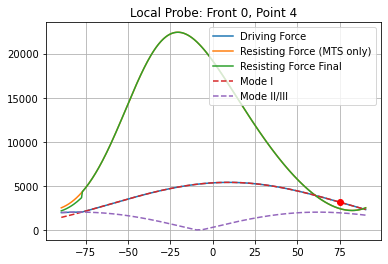

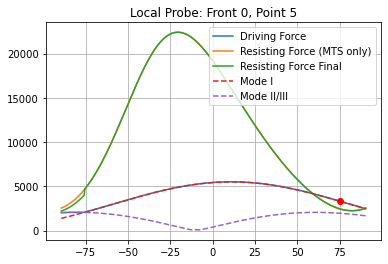

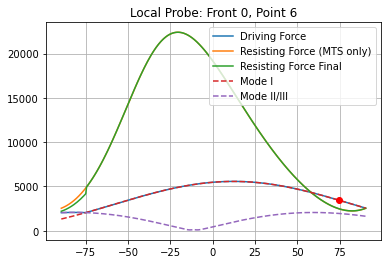

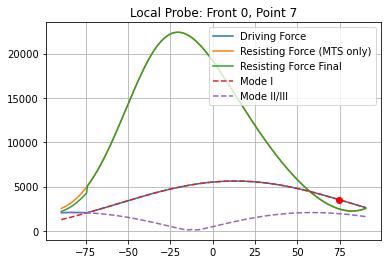

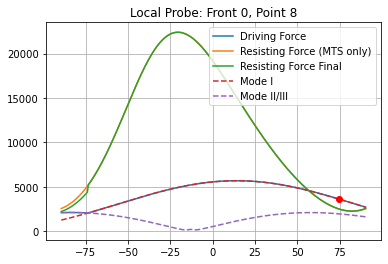

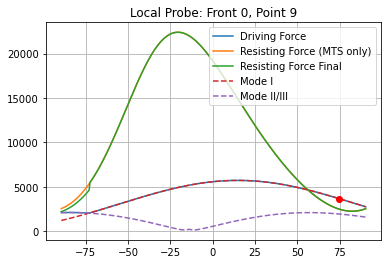

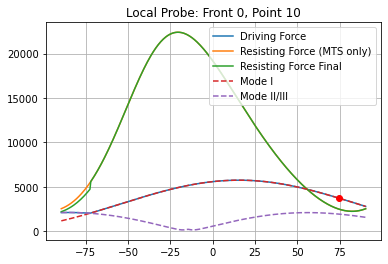

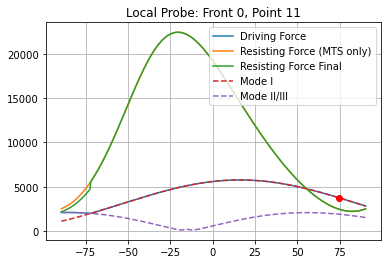

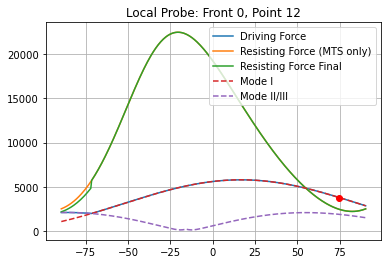

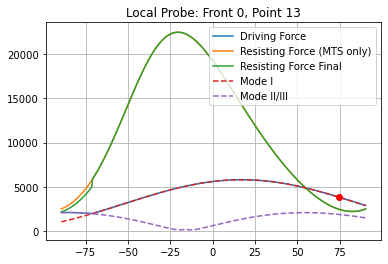

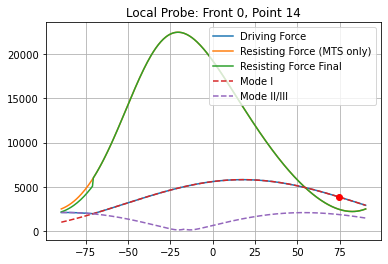

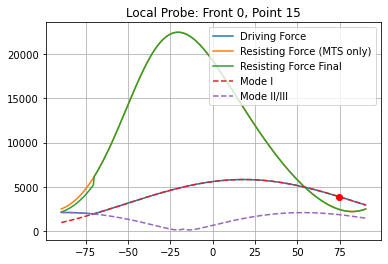

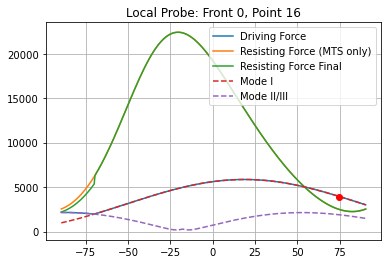

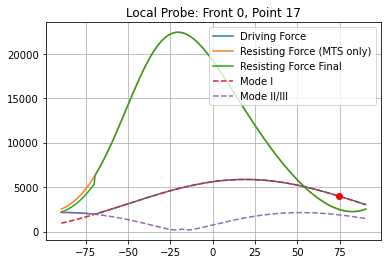

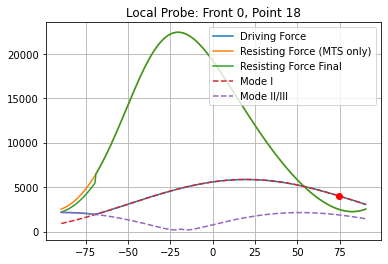

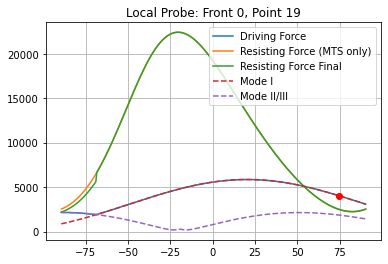

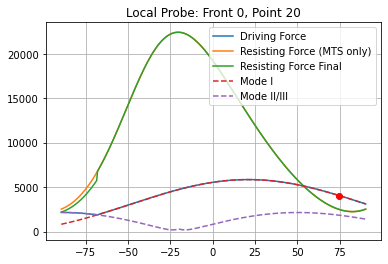

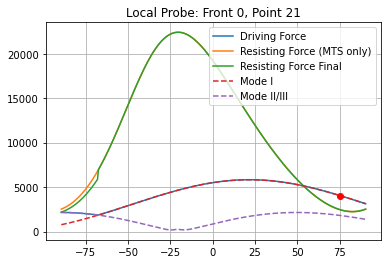

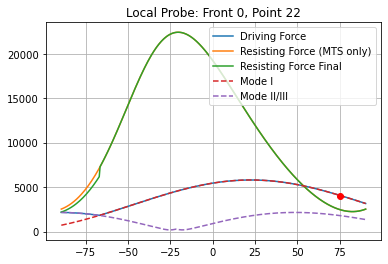

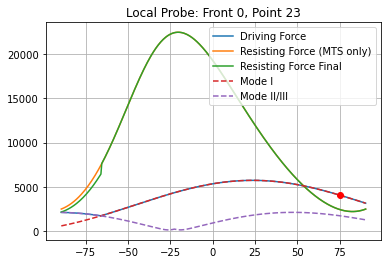

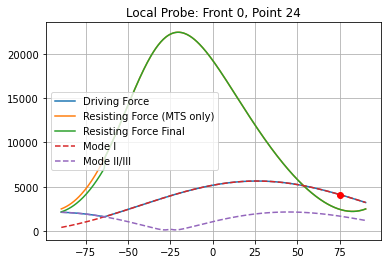

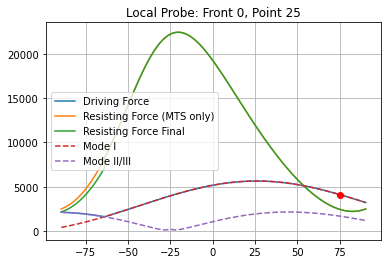

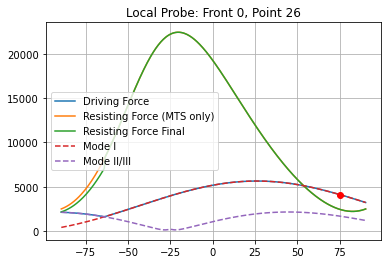

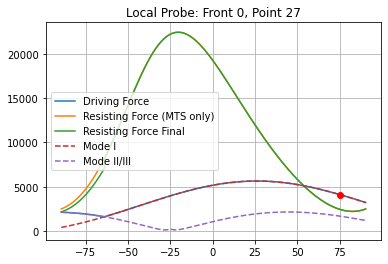

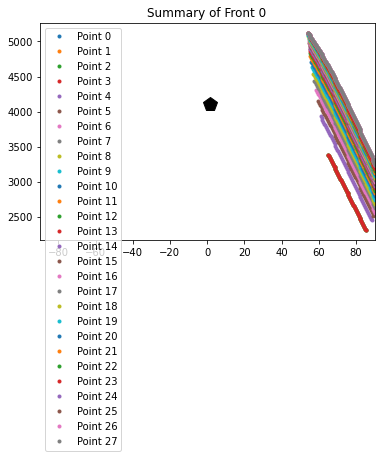

##############################                 FRANC 3D: On initiation site 0 front 0: 
##############################                 FRANC 3D: Kink angle on step 14 UCI 0 is: 74.99465626382296 degrees.



TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [149]:

# Write all the fronts to file
num_pts,Front_Mult,KINK,EXTENSION = [],[],[],[]
for front_ in range(SimDict['Edge']): # Loop through each crack fronts 
    # Compute KIc for this current crack based on current crack length and R curve
    curr_crack_length = .5
    K1c_parallel = R_curve( curr_crack_length , SimDict['K1c_0'] )

    fronts = [] # Old crack front coordinates
    for _ in range(len(lines)): # Loop through lines in the frt file
        if ('OLD_FRT_PTS: '+str(front_) in lines[_]):
            num_pts.append(int(lines[_][14:])) # Read number of points
            for __ in range(_+1 , _+num_pts[front_]+1): # Loop through all available points
                temp = []
                for item in lines[__].split(' '):
                    try:
                        temp.append(float(item)) # Coordinates of the old crack front points
                    except:
                        pass
                fronts.append( np.array(temp) )
            break
               
    # Calculate kink angle using the crack front point with median K_equivalent
    # Read SIF data along the front
    FN = SimDict['NAME'] + '.sif'
    [K1,K2,K3,Front_Axes] = Parse_SIF (FN)

    # Compute an equivalent K using all 3 modes of SIF (sign comes from the sign of K1)
    beta2 = np.abs( K2 ) / ( np.abs(K2) + np.abs(K3) )
    beta3 = np.abs( K3 ) / ( np.abs(K2) + np.abs(K3) )
    K_equivalent = np.sqrt( K1**2 + beta2 * K2**2 + beta3 * K3**2 )

    # Identify the sense (outward is desired) of the surface normal
    # This can be done by comparing the minimum distance from either end of the old crack front
    # to the nodes on the outer surface of the bone region
    DISTANCE1 , DISTANCE2 = [] , []
    for _ in LOC :
        DISTANCE1.append( -1 * np.linalg.norm( np.array(fronts[0] ) - _ ) )
        DISTANCE2.append( -1 * np.linalg.norm( np.array(fronts[-1] ) - _ ) )

    # Get top point on the extended front
    old_front = fronts[0] - fronts[-1] # The old crack front vector
    mag_old_front = np.linalg.norm( old_front ) # Length of the old crack front

    if ( min(DISTANCE1) < min(DISTANCE2) ): # Meaning that front point 0 is on the top surface
        top_surface_index = 0
    else: # Meaning that front point -1 (last one) is on the top surface
        old_front *= -1 
        top_surface_index = -1

    Top_point = np.array( fronts[top_surface_index] )
    Local_Normal = [0.,0.,1.] #Get_Normal( Top_point , old_front )
    
    # Global material toughness axis (Cylinderical), predefined in Set_Impact_ConfiguSimDict['ratio']n.py
    # The polar(z) axis passes through the ossification center, Location of the ossification center
    Material_X,Material_Y,Material_Z,OC = COORD
    
    # Mapping that transforms the global coordinate system to the material coordinate (2D)
    Transform = np.linalg.inv( np.matrix(np.transpose([Material_X,Material_Y,Material_Z])) )

    Overall_max_K_resolved = []
    Front_Kink_Angle = []

    # On May 23 2019, we decided to perform averaging over the crack front to smooth out the SIFs
    # 20% of the crack front nodes will be averaged, with a minimum number of 3 points to average
    Num_pt_avg = max( int(round(0.2*len(K1))) , 3 )
    print('##############################                 FRANC 3D: ' + str( Num_pt_avg ) + ' neighboring crack front nodes will be averaged.')

    plot_kink_angles_summary = []
    plot_summary = []
    for kink_node in range(len(K1)): # Loop through all nodes at the crack front
        Local_X = Front_Axes[kink_node][0] # Along the direction of crack advancement 
        Local_Z = Front_Axes[kink_node][2] # Along the crack axis, outward
        # Check sense of the Z axis (it should be outward by default but just to be safe)
        if (np.dot(old_front,Local_Z)<=0):
            Local_Z *= -1 # Original Z axis is inward, flip the sense
        Local_Y = np.cross(Local_Z,Local_X) # Recompute the local Y axis so the local coordinate is right-handed

        # Compute average SIFs at this current node
        Start_Ind = max( 0 , kink_node - Num_pt_avg/2 )
        End_Ind = min( len(K1) , kink_node + Num_pt_avg/2 + 1 )
        if ( Start_Ind == 0 ):
            End_Ind = Num_pt_avg
        if ( End_Ind == len(K1) ):
            Start_Ind = len(K1) - Num_pt_avg

        # Actually convert these into ints for python 3
        # In old version, inconsistent averaging due to using FLOATS for slices!!!!
        Start_Ind = int(math.ceil(Start_Ind))
        End_Ind = int(math.floor(End_Ind))

        K1_avg = np.mean( K1[Start_Ind:End_Ind] )
        K2_avg = np.mean( K2[Start_Ind:End_Ind] )
        K3_avg = np.mean( K3[Start_Ind:End_Ind] )

        # Sweep through angles from -90 to 90 to obtain kink angle
        # Initialize kink angle and max K (resolved)
        t = -np.pi / 2
        MAX_K_theta = -1*float('inf')
        Kink_angle = 0

        plot_x = []
        plot_k_mts = []
        plot_k_mss = []
        plot_driving = []
        plot_resisting = []
        plot_exceeds = []
        plot_resisting_shear = []

        plot_kink_angles_summary.append([])
        plot_summary.append([])

        f = plt.figure()
        
        k_delta_max = 0 # BRP: Delta Modification
        while ( t <= np.pi/2 ):
            # Compute the resolved K (Driving force)
            # Max. tensile stress criterion:
            K1_resolved = m.cos(t/2) *( K1_avg * m.cos(t/2)**2 - 1.5 * K2_avg * m.sin(t) )
            K_MTS = K1_resolved

            # Max. shear stress criterion:
            K2_resolved = abs(0.5*m.cos(t/2)*( K1_avg * m.sin(t) - K2_avg * (3*m.cos(t) - 1) ))
            K3_resolved = abs(K3_avg*m.cos(t/2))

            # Compute weight of the Mode II and III factors based on their relative magnitudes
            K2_weight = K2_resolved/(K2_resolved+K3_resolved)
            K3_weight = K3_resolved/(K2_resolved+K3_resolved)

            K_MSS = m.sqrt( (K2_weight*K2_resolved)**2 + (K3_weight*K3_resolved)**2 )
            
            # Use the generalized stress criterion for driving force
            K_Dominant = max([K_MTS,K_MSS])

            # Compute the direction of a virtual extension of unit length (In gloabl cartesian coordinate)
            virtual_front = Local_Y*m.sin(t) + Local_X*m.cos(t)
            #print("\n\nt = " + str(t)) #TODO: DELETE THIS
            #print("KINK ANGLE = " + str(Kink_angle)) #TODO: DELETE THIS
            #print("VIRTUAL FRONT DIRECTION (global) = " + str(virtual_front)) #TODO: DELETE THIS

            # Compute the local fiber direction at the crack tip of the main crack front (In gloabl cartesian coordinate)
            local_fiber = Normalize(OC - np.array(fronts[kink_node]))
            #print("LOCAL FIBER DIRECTION (global) = " + str(local_fiber)) #TODO: DELETE THIS
            # Transform these directions to the material axis ( Change of basis )
            # Only the projection onto the X-Y plane is used since the material axis is assumed to be 2D
            Fiber_direction = np.array( Transform * np.matrix(local_fiber.reshape((3,1))) ).reshape((1,3))[0][:2]
            #print("FIBER DIRECTION (material) = " + str(Fiber_direction))#TODO: DELETE THIS
            Fiber_direction = Normalize(Fiber_direction)
            #print("FIBER DIRECTION (material) (normalized) = " + str(Fiber_direction))#TODO: DELETE THIS
            
            #print("Transform = " + str(Transform)) #TODO: delete this
            Virtual_Extension = np.array( Transform * np.matrix(virtual_front.reshape((3,1))) ).reshape((1,3))[0][:2]
            #print("VIRTUAL EXTENSION DIRECTION (material) = " + str(Virtual_Extension)) #TODO: DELETE THIS
            Virtual_Extension = Normalize(Virtual_Extension)
            # Calculate the angle between them
            tot_ang = np.arccos( np.dot(Fiber_direction , Virtual_Extension) )
            #print("VIRTUAL EXTENSION DIRECTION (material) (normalized) = " + str(Virtual_Extension)) #TODO: DELETE THIS

            # Calculate the fracture toughness at this kink angle (Resistance)
            K1c_theta = K1c_parallel *  (m.cos(tot_ang )**2) + SimDict['ratio'] * K1c_parallel * (m.sin(tot_ang )**2)
            
            K1c_real = K1c_theta * 1.0
            #if(abs(t) < 0.01):
            #    print("PROPAGATE CRACK") #TODO: DELETE THIS
            #    print("K1c_parallel = " + str(K1c_parallel))#TODO: DELETE THIS
            #    print("tot_ang = " + str(tot_ang))#TODO: DELETE THIS
            #    print("ratio = " + str(SimDict['ratio']))#TODO: DELETE THIS
            #    print("K1c_theta = " + str(K1c_theta))#TODO: DELETE THIS
            
            
            # Use KI_c to compute KII_c if crack grows in under shear stress
            if ( np.argmax([K_MTS,K_MSS]) == 1 ):
                K1c_theta *= np.sqrt(0.75)

            k_delta = K_Dominant - K1c_theta # BRP: Delta Modification
            # If K1 is max and local K1 is greater than local resistance, this is the kink angle
            #if ( K_Dominant >= MAX_K_theta and K_Dominant >= K1c_theta ):
            if (k_delta >= 0 and k_delta > k_delta_max): # BRP: Delta Modification
                k_delta_max = k_delta  # BRP: Delta Modification
                MAX_K_theta = K_Dominant
                Kink_angle = t
            t += 0.0087 # Using 0.25 degrees increment

            plot_x.append(t*180./np.pi)
            plot_k_mts.append(K_MTS)
            plot_k_mss.append(K_MSS)
            plot_driving.append(K_Dominant)
            plot_resisting.append(K1c_real)
            plot_resisting_shear.append(K1c_theta)
            

            if ( K_Dominant >= K1c_theta ):
                plot_kink_angles_summary[kink_node].append(t*180./np.pi)
                plot_summary[kink_node].append(K_Dominant)

        plt.plot(plot_x, plot_driving, label='Driving Force')
        plt.plot(plot_x, plot_resisting, label='Resisting Force (MTS only)')
        plt.plot(plot_x, plot_resisting_shear, label='Resisting Force Final')
        plt.plot(plot_x, plot_k_mts, '--',  label='Mode I')
        plt.plot(plot_x, plot_k_mss, '--', label='Mode II/III')
        plt.plot(Kink_angle*180/np.pi, MAX_K_theta, 'or')
        plt.grid()
        plt.legend()
        plt.title('Local Probe: Front {}, Point {}'.format(front_, kink_node))
        plt.show()


        Overall_max_K_resolved.append(MAX_K_theta)
        Front_Kink_Angle.append(Kink_angle)

    if ( max(Overall_max_K_resolved) != -1*float('inf') ): # Meaning a kink angle is found, crack growth will occur
        node_index = np.argmax(Overall_max_K_resolved) # Use the nodal location where the resolved K1 is max
        kink = Local_Y*m.sin(Front_Kink_Angle[node_index]) + Local_X*m.cos(Front_Kink_Angle[node_index])
        Kink_angle = Front_Kink_Angle[node_index]



        f = plt.figure()
        III = 0
        for thet, Ks in zip(plot_kink_angles_summary, plot_summary):
            plt.plot(thet, Ks, '.', label='Point {}'.format(III))
            III += 1
        plt.plot(Kink_angle, max(Overall_max_K_resolved), 'kp', markersize=14)
        plt.title('Summary of Front {}'.format(front_))
        plt.xlim([-90,90])
        plt.legend()
        plt.show()

        print('##############################                 FRANC 3D: ' + 'On initiation site ' + str(SimDict['Crack_Lookup'][front_]) +' front ' + str(front_) + ': ')
        print('##############################                 FRANC 3D: Kink angle on step '+str(SimDict['Current_Step']+Step_increment-1)+ ' UCI ' + str(SimDict['Unstable_iter']) + ' is: '+str(np.degrees(Kink_angle))+' degrees.\n')
   

        Top_point = fronts[top_surface_index] + median_extension * kink

        if ( Normal_Method == 1 ):
            Local_Normal =[0,0,1] #Get_Normal( Top_point , old_front ) # Compute surface normal on this point
        else:
            Local_Normal = Normalize(old_front)

        # Calculate crack front extensions
        Extension,Kink_angle = [] , []
        for N in range( num_pts[front_] ):
            Local_Y = Front_Axes[N][1] # Along the direction of crack advancement 
            Local_Z = Front_Axes[N][2] # Along the crack axis, outward
            Lambda = np.dot( (np.array(fronts[N])-np.array(Top_point)) , Local_Z ) / np.dot( Local_Normal , Local_Z )
            v = np.array(Top_point)-np.array(fronts[N]) + Lambda * Local_Normal
            Extension.append( np.linalg.norm(v) )
            Kink_angle.append( np.pi/2.0 - np.arccos( np.dot(Normalize(v) , Local_Y ) )  )

        # Update crack length history
        #SimDict['crack_length'][ SimDict['Crack_Lookup'][front_] ].append( curr_crack_length + np.mean(Extension) )

        # Assign front multiplier
        Front_Mult.append(1) # 1 means to propagate this front

    else: # Meaning crack growth on this front is not going to occur in this step
        #print('##############################                 FRANC 3D: On initiation site ' + str(SimDict['Crack_Lookup'][front_]) + ' front ' + str(front_) + ', no crack growth occurred in this step.')
        # Assign kink angle
        Kink_angle = np.zeros(num_pts[front_])
        # Assign extension
        Extension = np.zeros(num_pts[front_])
        # Assign front multiplier
        Front_Mult.append(0) # 0 means do not propagate this front

    # Store kink angle and extension information
    KINK.append(Kink_angle)
    EXTENSION.append( Extension )

In [ ]:
# trying to figure out this basis vector thingy
oc = [130.395996,46.6063,98.649696] #confirmed oc
radius = [130.233963618264, 46.4498346978785, 99.6239978610785] #idk what this next one i
vector = []
length =0 
for _ in range(3):
    vector.append(oc[_]-radius[_])
    length += vector[_]**2
print(vector)
print((length)**.5)

[0.16203238173599743, 0.15646530212149656, -0.9743018610784873]
1.0000000000000075


In [ ]:
# why does the datum only have two points instead of three?
# create same datum as is in sfx then find a point of the skull and move mitch's experiment to there.